<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Long_Term_Analysis_of_Equities_and_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:09:49 Starting...
14:09:49 Installing yfinance into Google notebook...
14:09:54 Installing arch into Google notebook...
14:10:01 Initialized.


/tmp/ipython-input-2957036660.py:2: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  gold.index=pd.DatetimeIndex(gold.index).to_period('B')


,Close
,XAU
Date,
1968-04-01,37.70
1968-04-02,37.30
1968-04-03,37.60
1968-04-04,36.95
1968-04-05,37.00
...,...
2026-01-28,5306.95
2026-01-29,5405.00


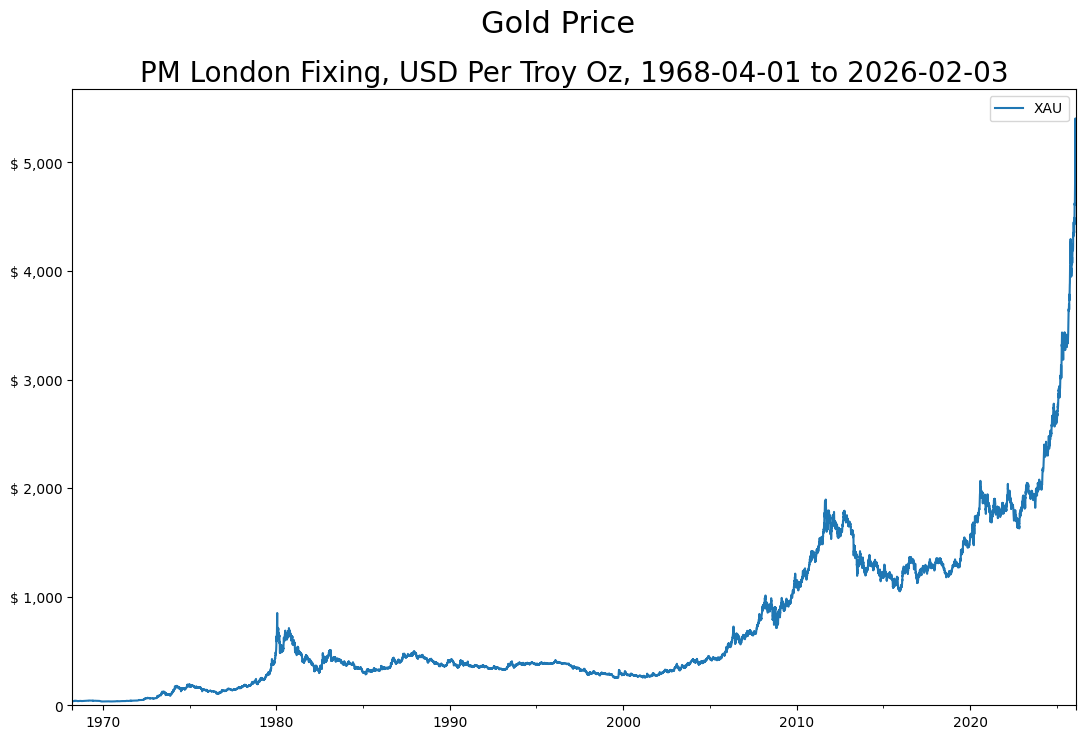

In [30]:
gold=pd.read_json("https://prices.lbma.org.uk/json/gold_pm.json")[["d","v"]].set_index("d")
gold.index=pd.DatetimeIndex(gold.index).to_period('B')
gold.index.name='Date'
gold[('Close',alternative:='XAU')]=gold['v'].apply(lambda x:x[0])
gold.drop('v',axis=1,inplace=True)
gold.columns=pd.MultiIndex.from_tuples(gold.columns)
display(gold)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
gold['Close'].plot(ax=plot)
figure.suptitle(title:='Gold Price (XAU/USD)',fontsize=22)
plot.set_title(subtitle:='PM London Fixing, USD Per Troy Oz, %s to %s' % (gold.index[0],gold.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3117114680.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.DatetimeIndex(data.index).to_period('B')
/tmp/ipython-input-3117114680.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred


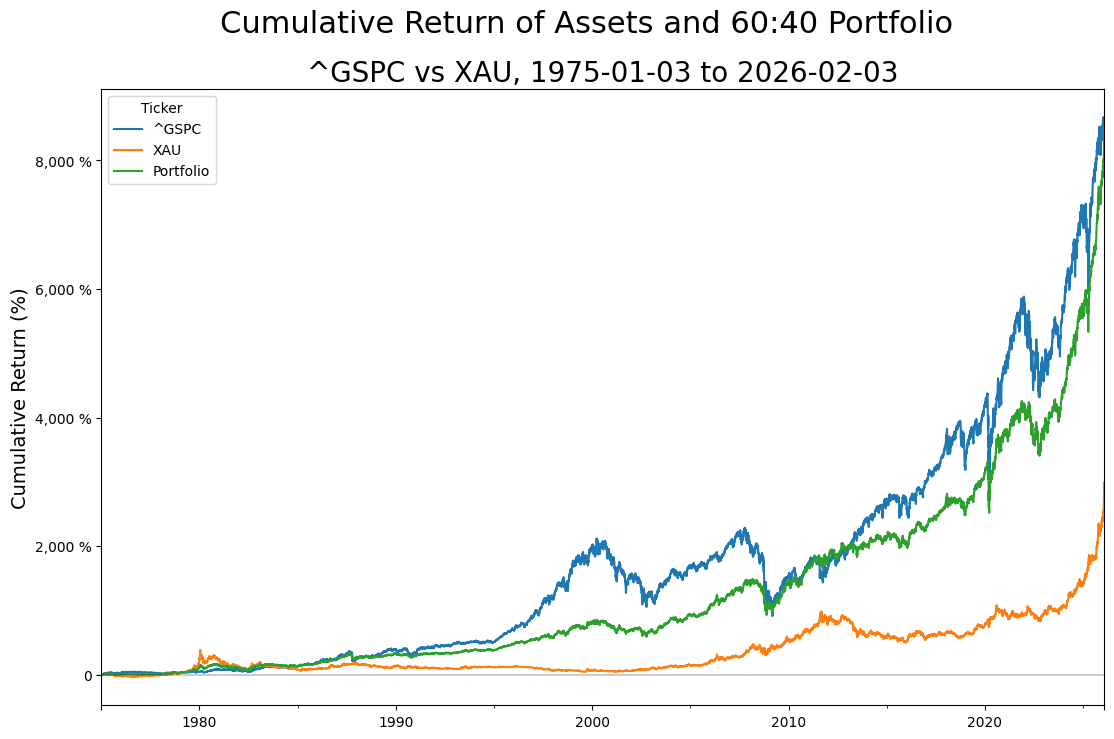

In [36]:
data=download(market:='^GSPC',"1975-01-01",today("%Y-%m-%d"),auto_adjust=True)
tickers=[market,alternative]
data.index=pd.DatetimeIndex(data.index).to_period('B')
data[('Close',alternative)]=gold[('Close',alternative)]
#data=data.resample('M').last()

for ticker in tickers:
    data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred
    data[('Weight',ticker)]=0.6 if ticker==market else 0.4

data.dropna(inplace=True)
data.sort_index(axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

for ticker in tickers+['Portfolio']:
    data[('Cumulative',ticker)]=(data[('Return',ticker)]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and 60:40 Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [37]:
from warnings import filterwarnings ; filterwarnings('ignore',category=pd.errors.PerformanceWarning)

report=pd.DataFrame({'Weight':np.arange(zero,one+(delta:=0.05),delta)}).set_index("Weight")

if data.index.dtype==pd.PeriodDtype('W'):
    annualize=52e0

elif data.index.dtype==pd.PeriodDtype('M'):
    annualize=12e0

elif data.index.dtype==pd.PeriodDtype('Q'):
    annualize=4e0

elif data.index.dtype==pd.PeriodDtype('Y'):
    annualize=1e0

for weight in tqdm(report.index):
    report.loc[weight,market]=weight
    report.loc[weight,alternative]=one-weight

    for ticker in tickers:
        data[('Weight',ticker)]=report.loc[weight,ticker]

    data.drop(('Return','Portfolio'),axis=1,inplace=True)
    data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

    report.loc[weight,'Sample']=(r:=data[('Return','Portfolio')]).count()
    report.loc[weight,'Mean']=(m:=r.mean())
    report.loc[weight,'Std.Dev.']=(s:=r.std())
    report.loc[weight,'Std.Err.']=r.sem()
    report.loc[weight,'Kurtosis']=r.kurt()+three

report['Sharpe']=report['Mean']/report['Std.Dev.']*annualize**half
report['Sharpe S.E.']=((annualize/report['Sample'])*(one+(report['Kurtosis']-one)/four*report['Sharpe']**two))**half

display(report)

  0%|          | 0/21 [00:00<?, ?it/s]

,^GSPC,XAU,Sample,Mean,Std.Dev.,Std.Err.,Kurtosis,Sharpe,Sharpe S.E.
Weight,,,,,,,,,
0.00,0.00,1.00,12561.0,0.033856,1.208090,0.010779,13.918803,0.444875,0.181345
0.05,0.05,0.95,12561.0,0.034243,1.148540,0.010248,13.921489,0.473292,0.185955
0.10,0.10,0.90,12561.0,0.034630,1.091890,0.009742,13.862426,0.503475,0.190827
0.15,0.15,0.85,12561.0,0.035017,1.038614,0.009267,13.723964,0.535218,0.195814
0.20,0.20,0.80,12561.0,0.035405,0.989257,0.008827,13.492958,0.568133,0.200716
0.25,0.25,0.75,12561.0,0.035792,0.944434,0.008427,13.168809,0.601603,0.205308
0.30,0.30,0.70,12561.0,0.036179,0.904820,0.008073,12.774615,0.634733,0.209416
0.35,0.35,0.65,12561.0,0.036566,0.871125,0.007773,12.368744,0.666339,0.213025
0.40,0.40,0.60,12561.0,0.036953,0.844058,0.007531,12.050304,0.694987,0.216407


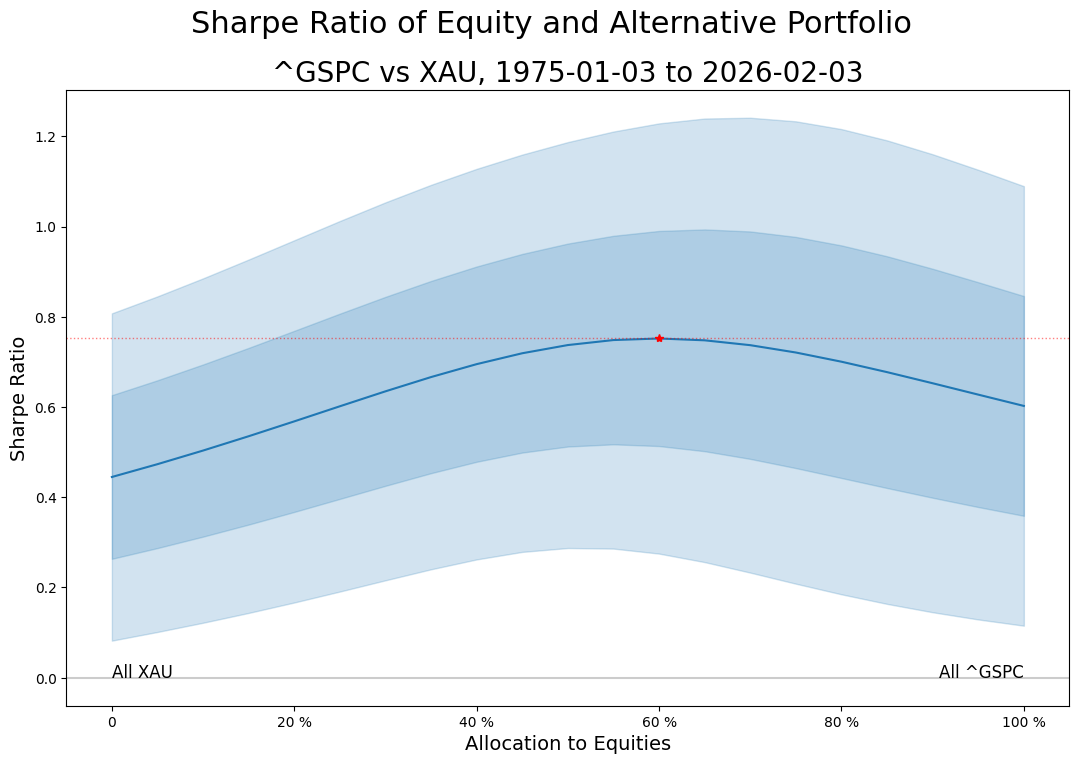

In [38]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index)*hundred,y:=report.loc[x,'Sharpe'])
plot.fill_between(x*hundred,y+(ye:=report.loc[x,'Sharpe S.E.']),y-ye,color='C0',alpha=0.2)
plot.fill_between(x*hundred,y+two*ye,y-two*ye,color='C0',alpha=0.2)
figure.suptitle(title:='Sharpe Ratio of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Sharpe Ratio',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[y.argmax()]*hundred,y.max(),'r*')
plot.axhline(y.max(),color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

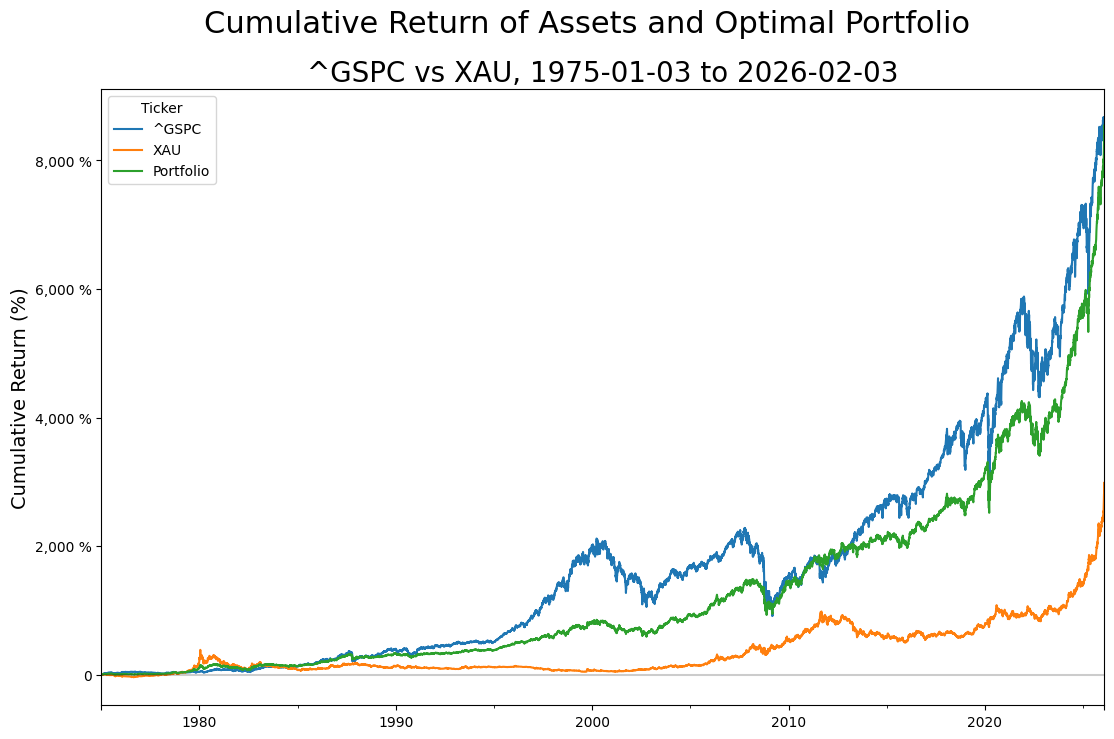

In [39]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and Optimal Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')